In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from json import dump
np.random.seed(0)

In [2]:
def squared_error(y, y_hat):
    return np.sum(np.power(y - y_hat, 2))

In [3]:
def rmse(y, y_hat):
    return np.sqrt(np.mean(np.power(y - y_hat, 2)))

In [4]:
def r2_score(y, y_hat):
    mean = np.array([np.mean(y)] * y.shape[0])
    regr_err = squared_error(y, y_hat)
    mean_err = squared_error(y, mean)
    
    return 1 - regr_err / mean_err

In [5]:
def akaike(y, y_hat, k_ar, k_am):
    '''
    AIC estimates the relative amount of information lost by a given model: 
    the less information a model loses, the higher the quality of that model.
    
    y - outputs,
    y_hat - predicted output,
    k_ar - a[i]
    k_am - b[i]
    '''
        
    err = squared_error(y, y_hat)
    
    return y.shape[0] * np.log(err) + 2 * (k_ar + k_am + 1)

In [6]:
def shift(data, n):
    e = np.empty_like(data)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = data[:-n]
    
    else:
        e[n:] = np.nan
        e[:n] = data[-n:]
    
    return e

In [7]:
def generate_data(data, c, coef_ar, coef_am):
    '''
    data - our noise
    c - a0
    coeff_ar - [a1,a2,a2]
    coef_am - [b1,b2,b3]
    '''
    
    y = data.copy()
    ar_c = len(coef_ar)
    am_c = len(coef_am)
    shift = am_c if am_c > ar_c else ar_c
    
    for i in range(0, y.shape[0] - shift):
        ar_part = c + np.sum(y[i:i + ar_c] * coef_ar[::-1])
        am_part = data[i+shift] + np.sum(data[i:i + am_c] * coef_am[::-1])
        y[i + shift] = ar_part + am_part
    
    return y

In [8]:
def prepare_data(data, noise, k_ar, k_am):
    '''
    data - generated data
    npise - noise
    k_ar - len([a1,a2,a2])
    k_am - len([b1,b2,b3])
    '''
        
    new_data = np.ones(shape=(data.shape[0], 1))
    
    for i in range(1, k_ar + 1):
        new_data = np.concatenate([
            new_data,
            shift(data, i).reshape((-1, 1))
        ], axis=1)
    
    new_data = np.concatenate([
        new_data, noise.reshape((-1, 1))], axis=1)
    
    for i in range(1, k_am + 1):
        new_data = np.concatenate([
            new_data,
            shift(noise, i).reshape((-1, 1))
        ], axis=1)
    
    idx_x = ~np.isnan(new_data).any(axis=1)
    
    return new_data[idx_x], data[idx_x]

In [9]:
def solve_normal_equation(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

In [10]:
def solve_recursive(X, y):
    p0 = np.eye(X.shape[1]) * 10
    theta = np.zeros((X.shape[1], ))
    theta_log = []
    
    for i in range(X.shape[0]):
        x_i = X[i].reshape((1, -1))
        numerator = p0.dot(x_i.T).dot(x_i).dot(p0)
        denominator = 1 + x_i.dot(p0).dot(x_i.T)
        
        p1 = p0 - numerator / denominator
        theta = theta + p1.dot(x_i.T).dot(y[i].T - x_i.dot(theta))
        
        p0 = p1
        theta_log.append(theta.copy())

    return theta, np.array(theta_log)

In [11]:
def predict(X, theta):
    return X.dot(theta)

In [12]:
def find_best_model(data, noise, ar_params, ma_params, write_plots):
    '''
    data - our data,
    noise - is noise,
    write_plots - True/False for writing plots
    '''
    models = dict()
    theta_logs = dict()
    
    for ar_p in ar_params:
        for ma_p in ma_params:
            name = f'ARMA({ar_p}, {ma_p})'
            X, y = prepare_data(data, noise, ar_p, ma_p)

            log_norm = dict()
            theta_normal = solve_normal_equation(X, y)
            pred_normal = predict(X, theta_normal)
            log_norm['rmse'] = rmse(y, pred_normal)
            log_norm['r2'] = r2_score(y, pred_normal)
            log_norm['akaike'] = akaike(y, pred_normal, ar_p, ma_p)
            log_norm['theta'] = list(theta_normal)

            log_recr = dict()
            theta_recursive, theta_log = solve_recursive(X, y)
            pred_recursive = predict(X, theta_recursive)
            log_recr['rmse'] = rmse(y, pred_recursive)
            log_recr['r2'] = r2_score(y, pred_recursive)
            log_recr['akaike'] = akaike(y, pred_recursive, ar_p, ma_p)
            log_recr['theta'] = list(theta_recursive)
            theta_logs[name] = theta_log

            models[name] = {
                'normal': log_norm,
                'recursive': log_recr
            }

            if write_plots:
                x_range = np.arange(X.shape[0])
                path = Path('./plots')
                path.mkdir(parents=True, exist_ok=True)

                plt_normal = name + '_normal.png'
                plt.plot(x_range, y, color='blue', label='True value')
                plt.plot(x_range, pred_normal, '--', color='red', label='Pedicted value')
                plt.title(name + '_normal')
                plt.xlabel('x')
                plt.ylabel('y')
                
                plt.show()
                plt.savefig(path / plt_normal)
                plt.close()

                plt_recursive = name + '_recursive.png'
                plt.plot(x_range, y, color='blue', label='True value')
                plt.plot(x_range, pred_recursive, '--',color='red', label='Pedicted value')
                plt.title(name + '_recursive')
                plt.xlabel('x')
                plt.ylabel('y')
                
                plt.show()
                plt.savefig(path / plt_recursive)
                plt.close()

    return models, theta_logs

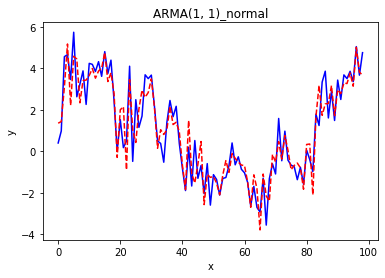

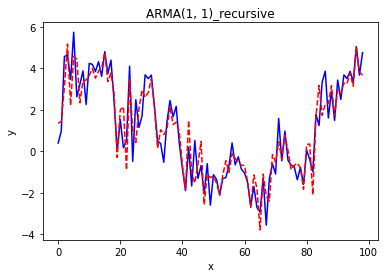

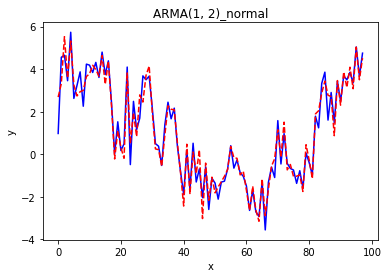

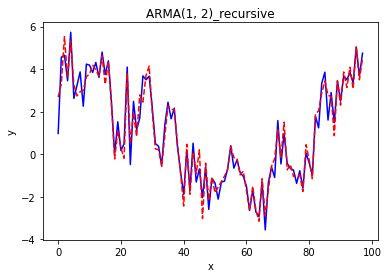

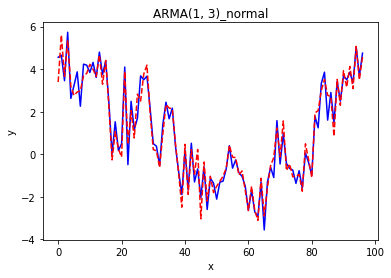

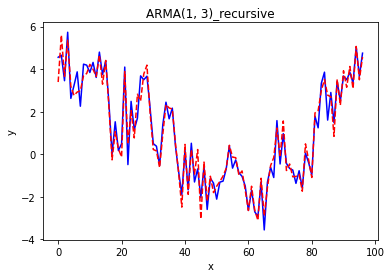

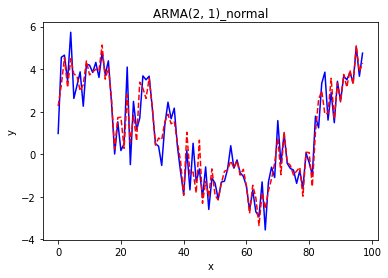

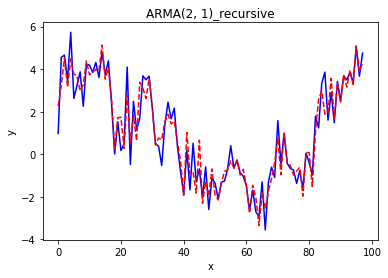

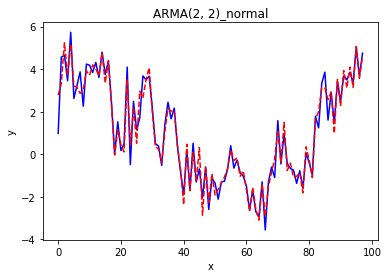

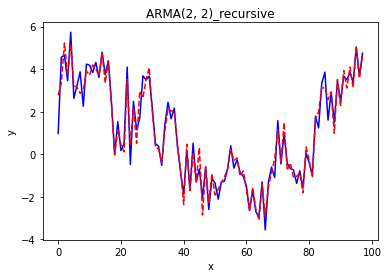

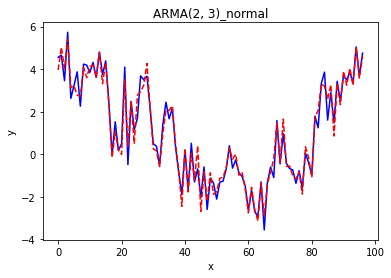

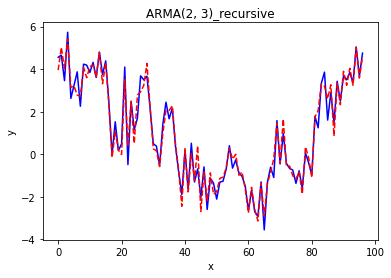

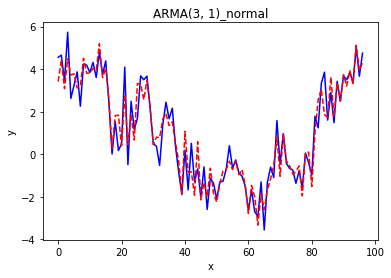

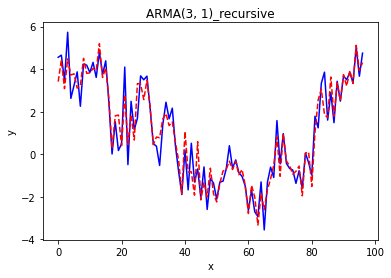

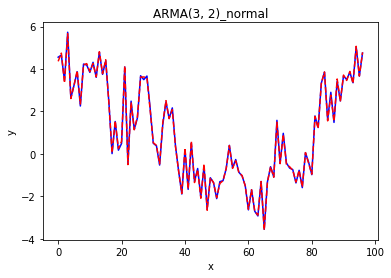

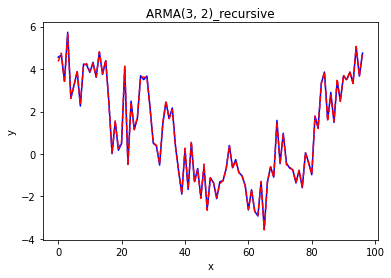

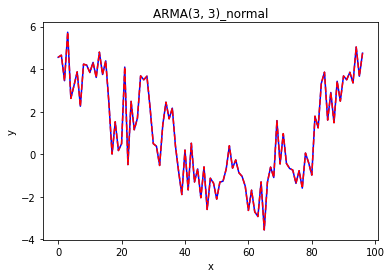

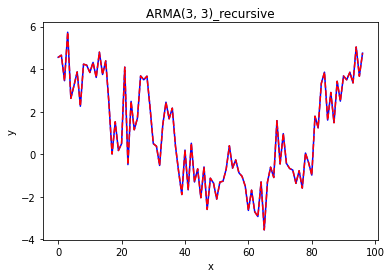

In [13]:
noise = np.random.normal(size=(100, ))
data = generate_data(
        noise,
        0.4,  # a0
        np.array([0.05, 0.05, 0.5]),  # a1..a3
        np.array([0.4, 1, 0.1]))  # b1..b3

params, logs = find_best_model(data, noise, [1, 2, 3], [1, 2, 3], True)
with open('results.json', 'w') as f:
    dump(params, f, indent=4)


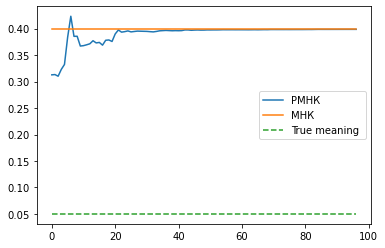

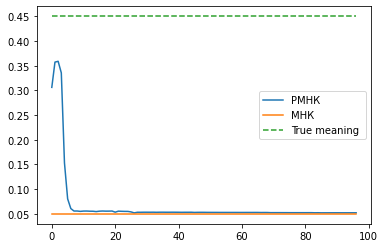

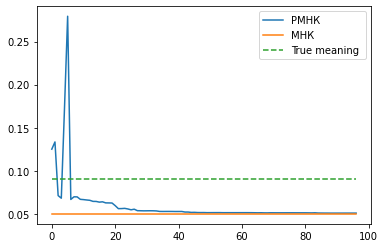

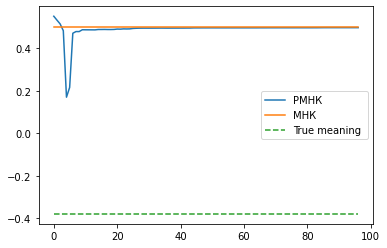

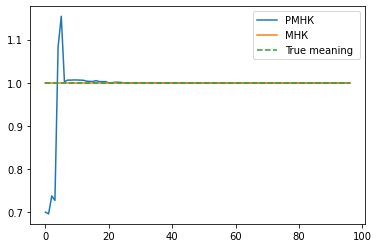

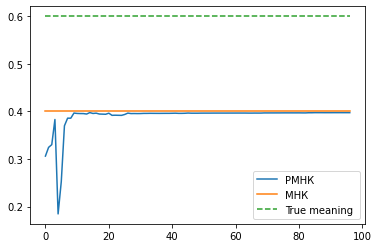

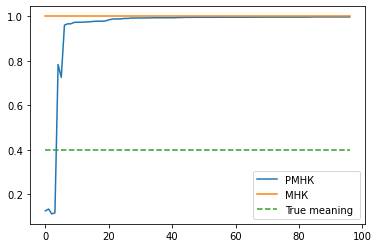

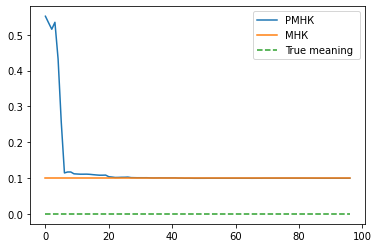

In [14]:
shape = logs['ARMA(3, 3)'].shape[0]
X = np.arange(shape)
path = Path('./params')
path.mkdir(parents=True, exist_ok=True)

param_names = ['a0', 'a1', 'a2', 'a3', 'b0', 'b1', 'b2', 'b3']
theta_real = np.array([0.05, 0.45, 0.09, -0.38, 1, 0.6, 0.4, 0])

for i in range(len(param_names)):
    plt.plot(X, logs['ARMA(3, 3)'][:, i], '-', label='РМНК')
    plt.plot(X, [params['ARMA(3, 3)']['normal']['theta'][i]] * shape, label='МНК')
    plt.plot(X, [theta_real[i]] * shape, '--', label='True meaning ')
    plt.legend()
    plt.show()
    plt.savefig(path / f'{param_names[i]}.png')
    plt.close()